# **Cancer Detection Challenge**

Histopathologic Cancer Detection competition focuses on a critical medical image classification task to identify metastatic cancer in small digital pathology images. This challenge is derived from the PatchCamelyon (PCam) benchmark dataset.
Metastasis detection in lymph nodes is a crucial but time-consuming task for pathologists. When cancer metastasizes, it spreads from the primary site to other parts of the body, often through the lymphatic system. Pathologists must carefully examine lymph node sections to identify microscopic evidence of metastasis, which directly impacts cancer staging, treatment decisions, and patient prognosis. Automated detection systems could significantly improve efficiency and potentially reduce diagnostic variability.

**Dataset characteristics:**
- Total image size: 96×96 pixels
- Central ROI used for classification: 32×32 pixels
- Binary classification:
  - Positive (1): Center 32×32 region contains tumor tissue
  - Negative (0): Center 32×32 region contains no tumor tissue
- Image Format: Small pathology images (96×96 pixels)(RGB color)
- Labeling Criteria: Positive label indicates that the center 32×32 pixel region contains at least one pixel of tumor tissue
- Dataset Partitioning: Split into training and testing sets
- File Organization:
  - Images are stored in train and test folders
  - Ground truth labels for training images are provided in the train_labels.csv file
  - Each image is identified by a unique ID, which is used in the filename

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.notebook import tqdm
import random
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks, applications
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define paths 
BASE_DIR = '../input/histopathologic-cancer-detection/'  # Kaggle input path
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
TRAIN_LABELS_PATH = os.path.join(BASE_DIR, 'train_labels.csv')

# Load the training labels
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)

print(f"Dataset loaded: {len(train_labels_df)} images")
print(train_labels_df.head())

# Use only half of the dataset to reduce computational time
# Making sure to maintain class distribution
train_labels_df = train_labels_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(frac=0.5, random_state=SEED)
).reset_index(drop=True)

print(f"Using reduced dataset: {len(train_labels_df)} images")
print(train_labels_df.head())

Dataset loaded: 220025 images
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Using reduced dataset: 110012 images
                                         id  label
0  941ffe73059292e0effd4e81ca9363c117afc2f4      0
1  43b6acadb31161c9281460efa3fad0b992a92837      0
2  64cfb56ddf41e2a871ac5164d61e50b238b9ed1b      0
3  9464cf403653088420cdb78acacd8cf7fa2255e4      0
4  346bc5b2d383d70dfccb8fe9102c7f55687f5f52      0


<ipython-input-1-d827825483b8>:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_labels_df = train_labels_df.groupby('label', group_keys=False).apply(


# Exploratory Data Analysis 

Loading and examining the training labels. Analyzing the class distribution.


Class Distribution:
label
0    65454
1    44558
Name: count, dtype: int64
Percentage of positive samples: 40.50%


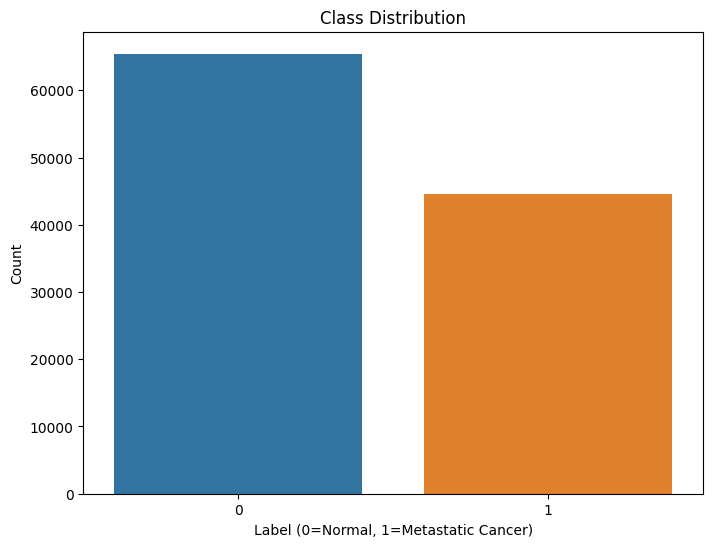

In [2]:
# Check class distribution
class_distribution = train_labels_df['label'].value_counts()
print("\nClass Distribution:")
print(class_distribution)
print(f"Percentage of positive samples: {class_distribution[1]/len(train_labels_df)*100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels_df)
plt.title('Class Distribution')
plt.xlabel('Label (0=Normal, 1=Metastatic Cancer)')
plt.ylabel('Count')
plt.show()

Total images: 220,025 (130,908 normal + 89,117 cancer). The dataset has an imbalance with 59.5% normal samples and 40.5% cancer samples which is not too severe.
Dataset is reduced to half to reduce the computational time.
Displaying sample images from both classes (cancer and normal).
Highlighting the critical 32x32 pixel center region that determines the label.

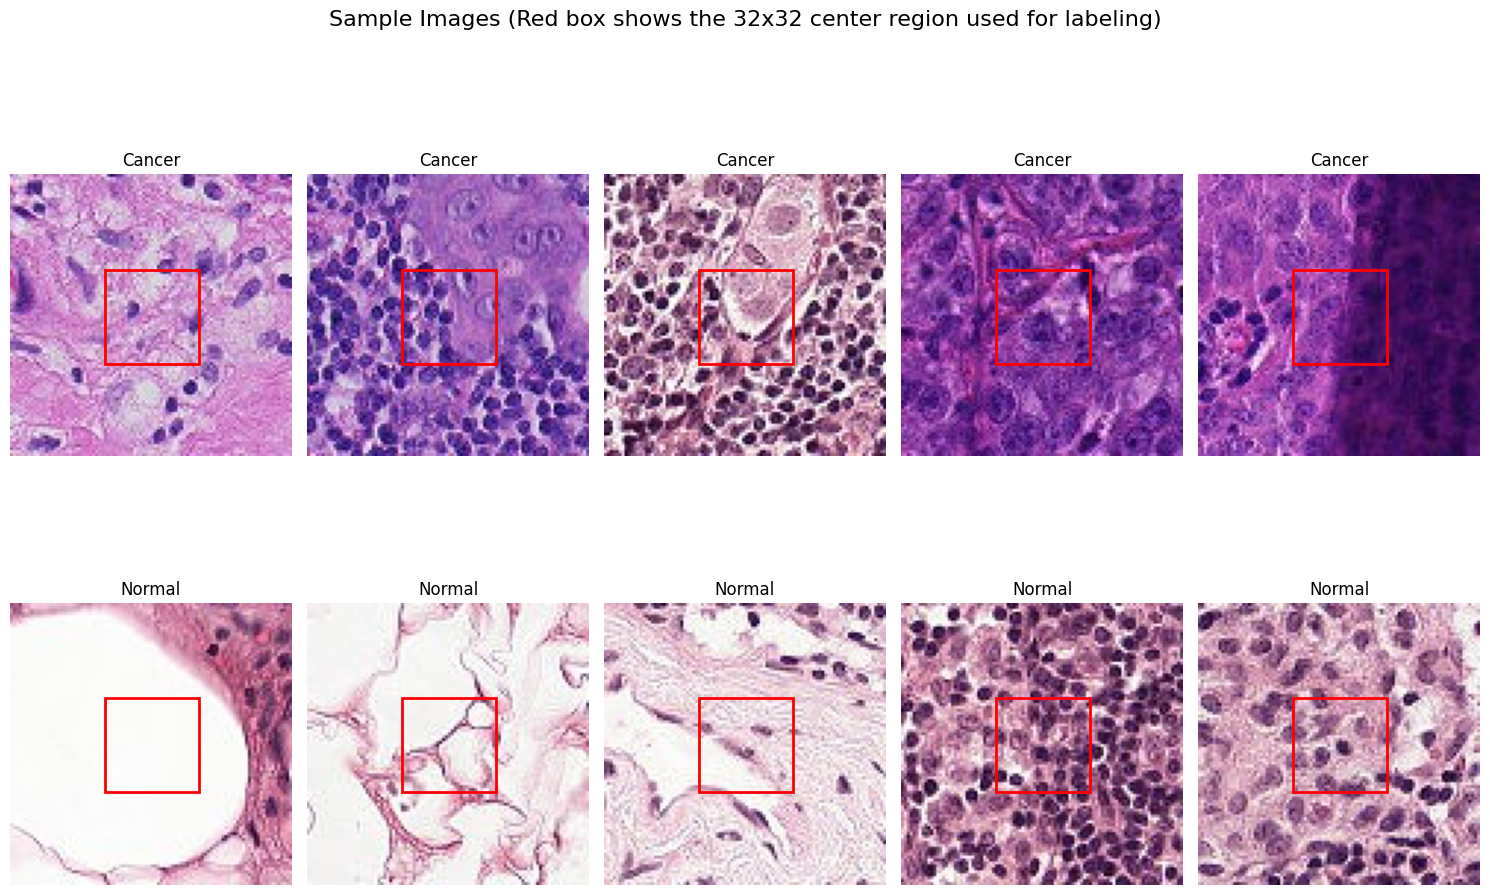

In [3]:
def load_and_display_samples(num_samples=5, figsize=(15, 10)):
    """
    Load and display sample images from both classes
    """
    # Get sample image IDs for each class
    pos_samples = train_labels_df[train_labels_df['label'] == 1]['id'].sample(num_samples).values
    neg_samples = train_labels_df[train_labels_df['label'] == 0]['id'].sample(num_samples).values
    
    # Set up the plot
    fig, axes = plt.subplots(2, num_samples, figsize=figsize)
    
    # Plot positive samples
    for i, img_id in enumerate(pos_samples):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = np.array(Image.open(img_path))
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Cancer")
        axes[0, i].axis('off')
        
        # Draw a box around the center 32x32 region that determines the label
        rect = plt.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
        axes[0, i].add_patch(rect)
    
    # Plot negative samples
    for i, img_id in enumerate(neg_samples):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = np.array(Image.open(img_path))
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Normal")
        axes[1, i].axis('off')
        
        # Draw a box around the center 32x32 region that determines the label
        rect = plt.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
        axes[1, i].add_patch(rect)
    
    plt.tight_layout()
    plt.suptitle("Sample Images (Red box shows the 32x32 center region used for labeling)", y=1.02, fontsize=16)
    plt.show()
    
# Display sample images
load_and_display_samples(num_samples=5)

Identifying potential color-based differences between cancer and normal samples.
Creating violin plots and histograms to compare color profiles.

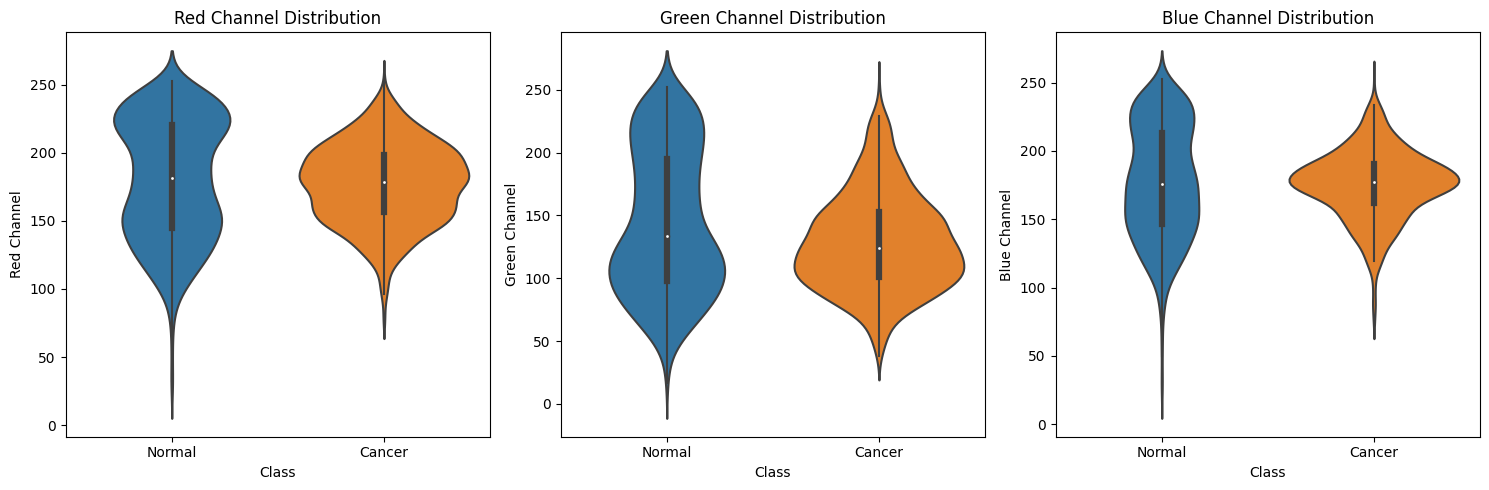

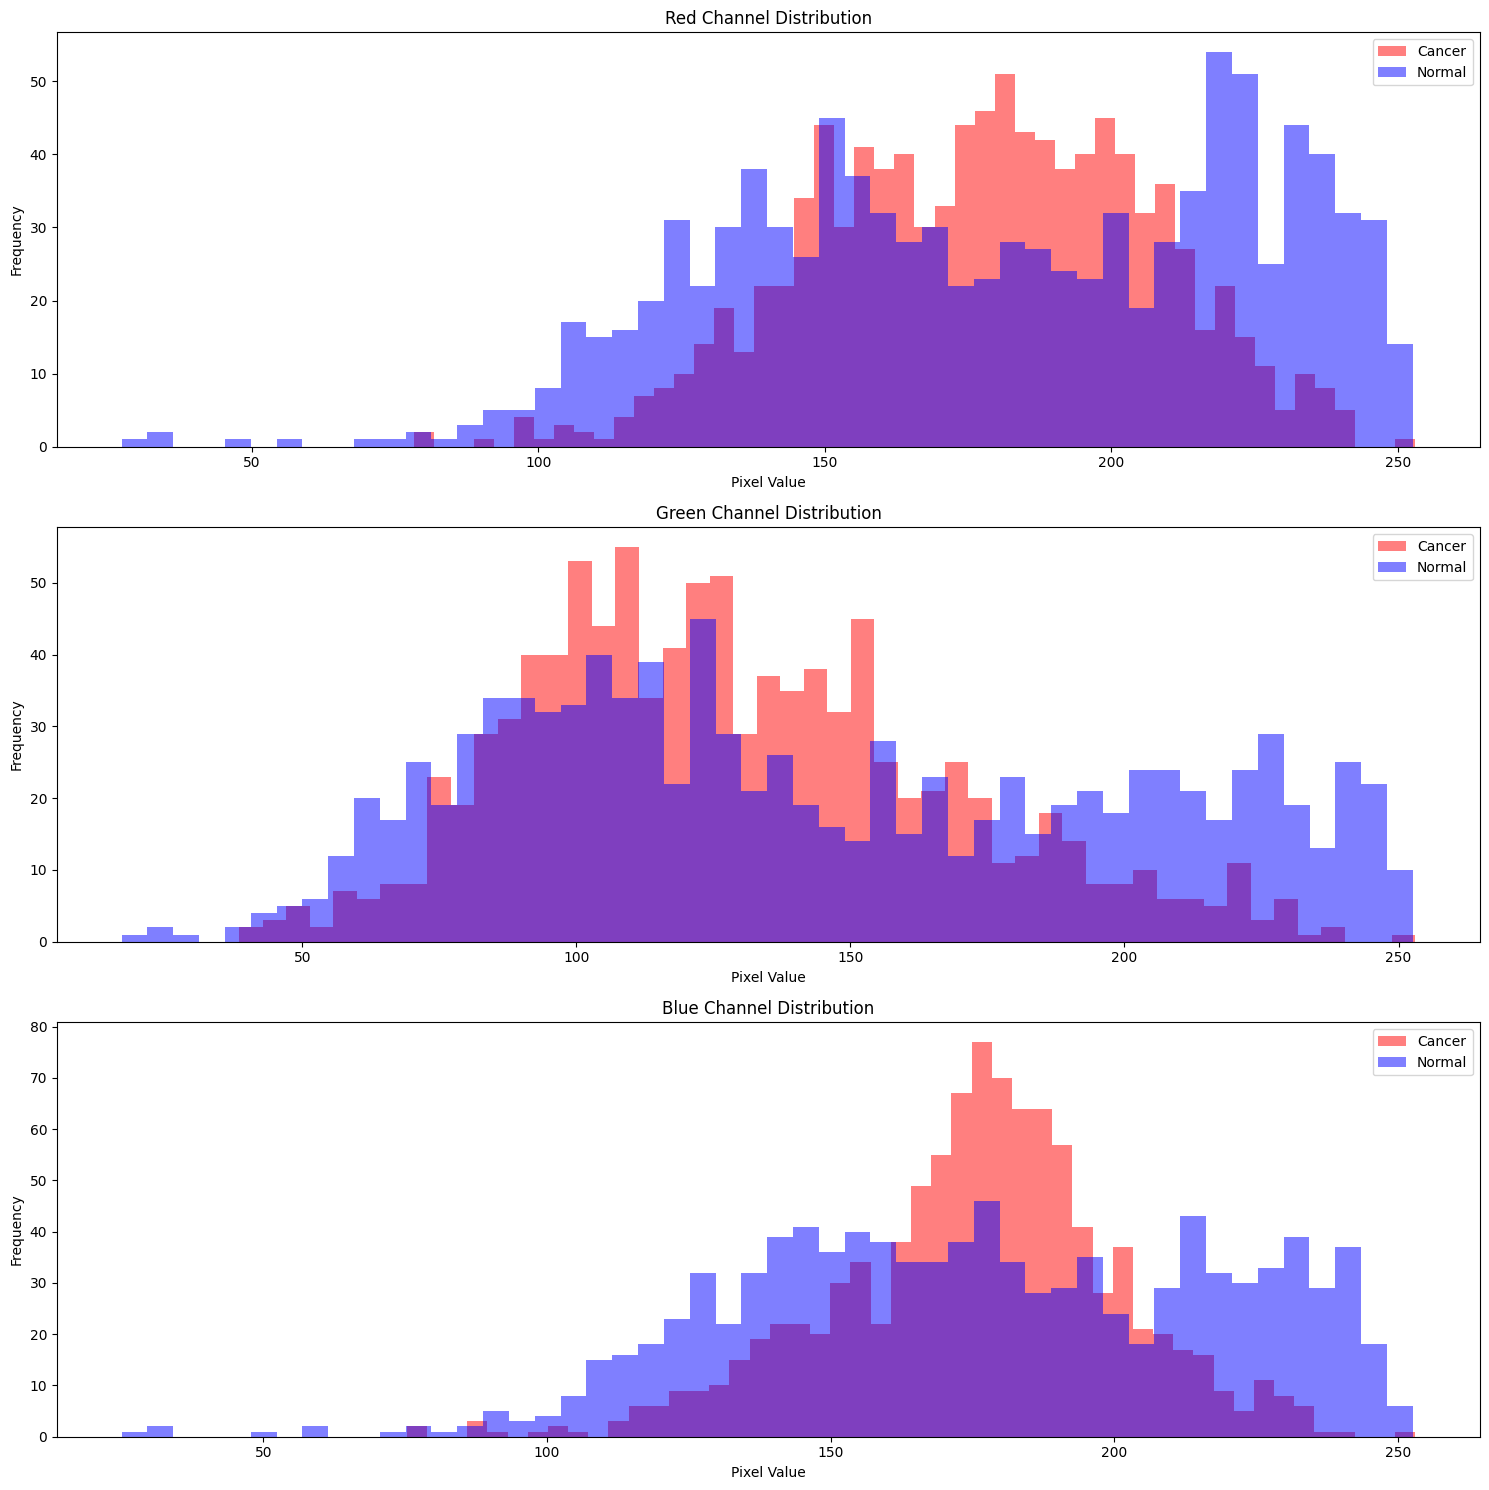

In [4]:
def analyze_color_distribution(num_samples=100):
    """
    Analyze the color distribution of images from both classes
    """
    # Get sample image IDs for each class
    pos_samples = train_labels_df[train_labels_df['label'] == 1]['id'].sample(num_samples).values
    neg_samples = train_labels_df[train_labels_df['label'] == 0]['id'].sample(num_samples).values
    
    # Initialize arrays to store color values
    pos_colors = np.zeros((num_samples, 3))  # RGB values
    neg_colors = np.zeros((num_samples, 3))
    
    # Extract color information for positive samples
    for i, img_id in enumerate(pos_samples):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = np.array(Image.open(img_path))
        
        # Get mean RGB values for the center 32x32 region
        center_img = img[32:64, 32:64, :]
        pos_colors[i] = np.mean(center_img, axis=(0, 1))
    
    # Extract color information for negative samples
    for i, img_id in enumerate(neg_samples):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = np.array(Image.open(img_path))
        
        # Get mean RGB values for the center 32x32 region
        center_img = img[32:64, 32:64, :]
        neg_colors[i] = np.mean(center_img, axis=(0, 1))
    
    # Create violin plots for each color channel
    channels = ['Red', 'Green', 'Blue']
    
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        
        # Create a DataFrame for plotting
        df = pd.DataFrame({
            'Normal': neg_colors[:, i],
            'Cancer': pos_colors[:, i]
        }).melt(var_name='Class', value_name=f'{channels[i]} Channel')
        
        sns.violinplot(x='Class', y=f'{channels[i]} Channel', data=df)
        plt.title(f'{channels[i]} Channel Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Create histograms for each color channel
    plt.figure(figsize=(15, 15))
    
    for i, channel in enumerate(channels):
        plt.subplot(3, 1, i+1)
        
        plt.hist(pos_colors[:, i], alpha=0.5, bins=50, label='Cancer', color='red')
        plt.hist(neg_colors[:, i], alpha=0.5, bins=50, label='Normal', color='blue')
        
        plt.title(f'{channel} Channel Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return pos_colors, neg_colors

# Analyze color distribution
pos_colors, neg_colors = analyze_color_distribution(num_samples=1000)

Cancer samples show distinctly different color distributions compared to normal samples.

Identifying potential texture-based discriminative features and comparing texture features with violin plots and box plots.

Processing cancer samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing normal samples:   0%|          | 0/1000 [00:00<?, ?it/s]

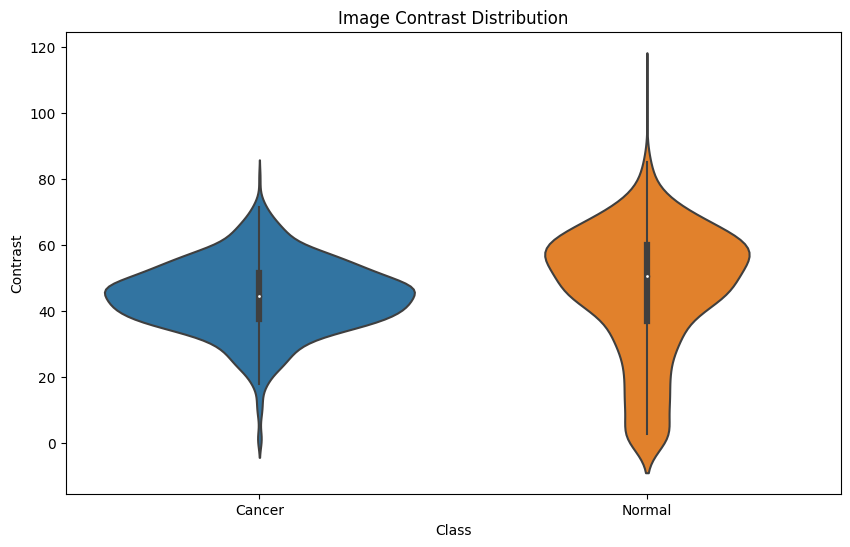

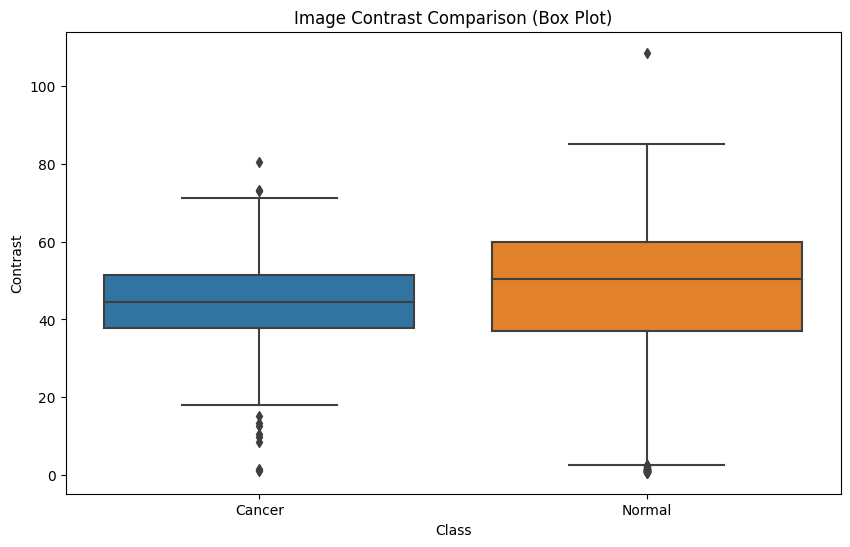

In [5]:
def analyze_image_texture(num_samples=100):
    """
    Analyze texture features: contrast, homogeneity, energy
    """
    # Get sample image IDs for each class
    pos_samples = train_labels_df[train_labels_df['label'] == 1]['id'].sample(num_samples).values
    neg_samples = train_labels_df[train_labels_df['label'] == 0]['id'].sample(num_samples).values
    
    # Initialize arrays for texture features
    pos_contrast = np.zeros(num_samples)
    neg_contrast = np.zeros(num_samples)
    
    # Calculate contrast for positive samples
    for i, img_id in enumerate(tqdm(pos_samples, desc="Processing cancer samples")):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = np.array(Image.open(img_path))
        
        # Convert to grayscale for texture analysis
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        center_gray = img_gray[32:64, 32:64]  # Center region
        
        # Calculate contrast (standard deviation as a simple measure)
        pos_contrast[i] = np.std(center_gray)
    
    # Calculate contrast for negative samples
    for i, img_id in enumerate(tqdm(neg_samples, desc="Processing normal samples")):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = np.array(Image.open(img_path))
        
        # Convert to grayscale for texture analysis
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        center_gray = img_gray[32:64, 32:64]  # Center region
        
        # Calculate contrast (standard deviation as a simple measure)
        neg_contrast[i] = np.std(center_gray)
    
    # Visualize the contrast distribution
    plt.figure(figsize=(10, 6))
    
    # Create a DataFrame for plotting
    contrast_df = pd.DataFrame({
        'Contrast': np.concatenate([pos_contrast, neg_contrast]),
        'Class': ['Cancer']*num_samples + ['Normal']*num_samples
    })
    
    # Create violin plots
    sns.violinplot(x='Class', y='Contrast', data=contrast_df)
    plt.title('Image Contrast Distribution')
    plt.show()
    
    # Create box plots
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Class', y='Contrast', data=contrast_df)
    plt.title('Image Contrast Comparison (Box Plot)')
    plt.show()
    
    return contrast_df

# Analyze image texture
contrast_df = analyze_image_texture(num_samples=1000)

Normal samples show higher contrast values than cancer samples.

Demonstrating what augmented images will look like.

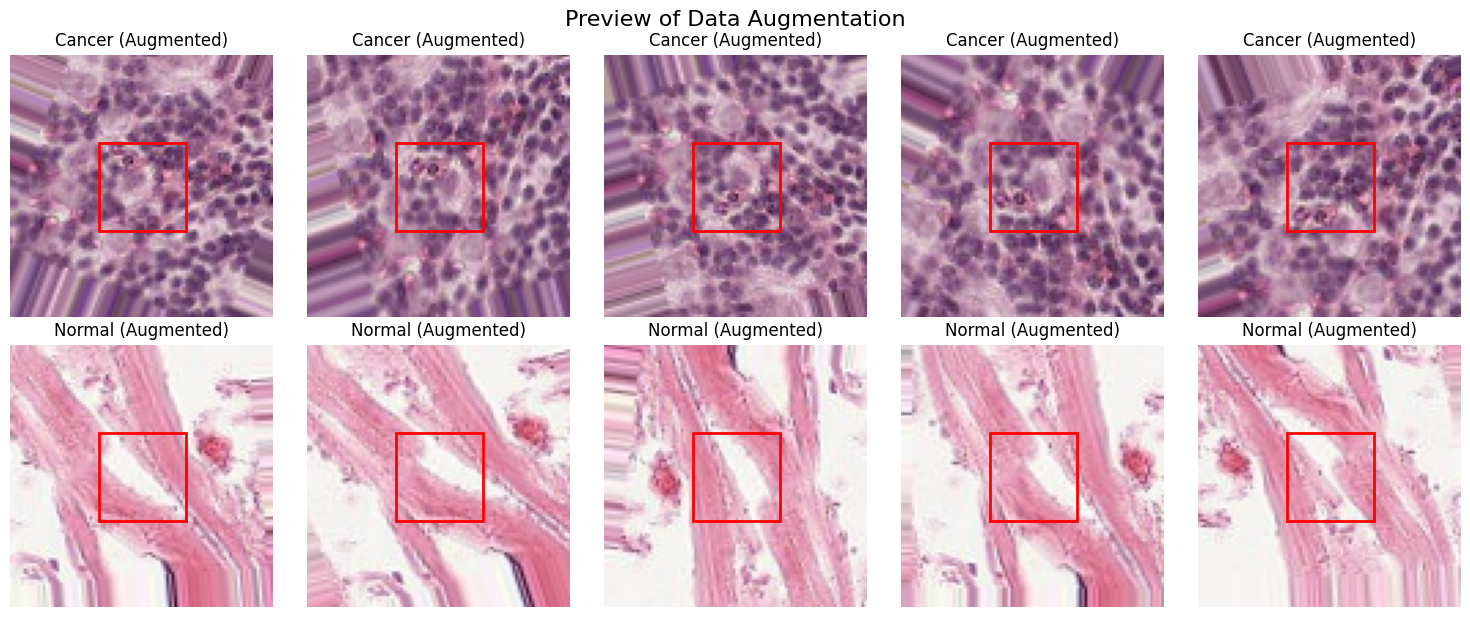

In [6]:
def preview_augmentations():
    """
    Preview what augmented images will look like
    """
    # Get one sample from each class
    pos_sample = train_labels_df[train_labels_df['label'] == 1]['id'].iloc[0]
    neg_sample = train_labels_df[train_labels_df['label'] == 0]['id'].iloc[0]
    
    # Load images
    pos_img_path = os.path.join(TRAIN_DIR, f"{pos_sample}.tif")
    neg_img_path = os.path.join(TRAIN_DIR, f"{neg_sample}.tif")
    
    pos_img = np.array(Image.open(pos_img_path))
    neg_img = np.array(Image.open(neg_img_path))
    
    # Create a data generator with augmentations
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    
    # Reshape images for the generator
    pos_img = pos_img.reshape((1,) + pos_img.shape)
    neg_img = neg_img.reshape((1,) + neg_img.shape)
    
    # Generate augmented images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    # Generate and plot augmented positive samples
    augmented_pos = [next(datagen.flow(pos_img, batch_size=1))[0].astype(np.uint8) for i in range(5)]
    for i, aug_img in enumerate(augmented_pos):
        axes[0, i].imshow(aug_img)
        axes[0, i].set_title(f"Cancer (Augmented)")
        axes[0, i].axis('off')
        
        # Draw a box around the center 32x32 region
        rect = plt.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
        axes[0, i].add_patch(rect)
    
    # Generate and plot augmented negative samples
    augmented_neg = [next(datagen.flow(neg_img, batch_size=1))[0].astype(np.uint8) for i in range(5)]
    for i, aug_img in enumerate(augmented_neg):
        axes[1, i].imshow(aug_img)
        axes[1, i].set_title(f"Normal (Augmented)")
        axes[1, i].axis('off')
        
        # Draw a box around the center 32x32 region
        rect = plt.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
        axes[1, i].add_patch(rect)
    
    plt.tight_layout()
    plt.suptitle("Preview of Data Augmentation", y=1.02, fontsize=16)
    plt.show()

# Preview data augmentations
preview_augmentations()

Examining overall intensity distributions for both classes.

Processing cancer samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing normal samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


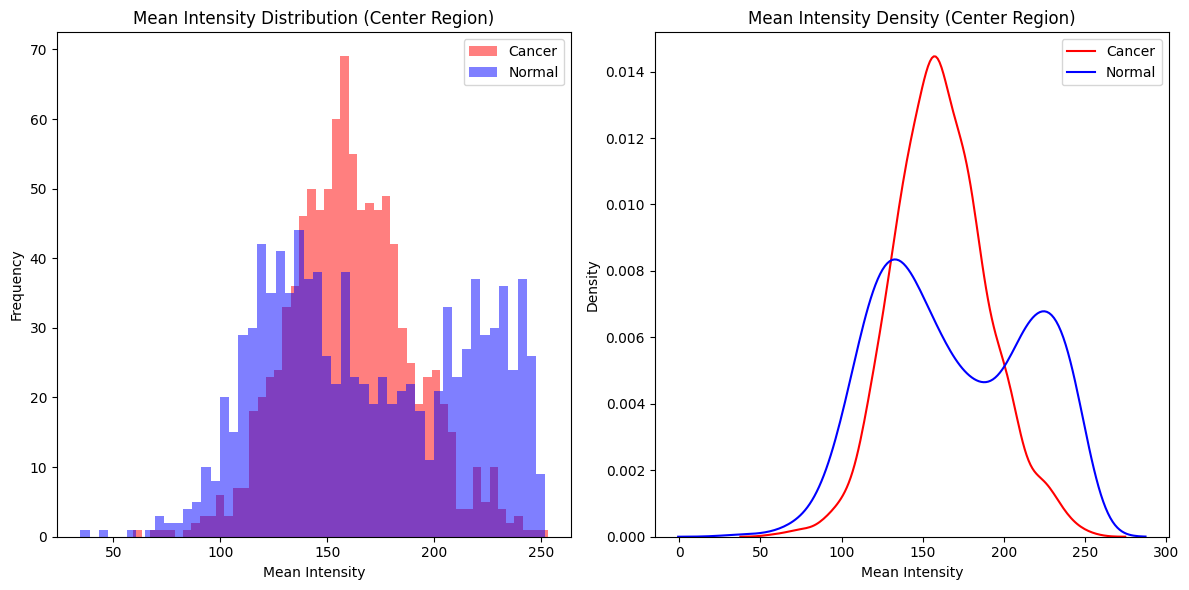


Intensity Statistics (Center Region):
Cancer samples - Mean: 160.99, Std: 28.63
Normal samples - Mean: 169.47, Std: 46.54


In [7]:
def analyze_image_intensity(num_samples=200):
    """
    Analyze image intensity characteristics of both classes
    """
    # Get sample image IDs for each class
    pos_samples = train_labels_df[train_labels_df['label'] == 1]['id'].sample(num_samples).values
    neg_samples = train_labels_df[train_labels_df['label'] == 0]['id'].sample(num_samples).values
    
    # Initialize arrays
    pos_intensity = np.zeros(num_samples)
    neg_intensity = np.zeros(num_samples)
    
    # Calculate intensity for positive samples (center region only)
    for i, img_id in enumerate(tqdm(pos_samples, desc="Processing cancer samples")):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = np.array(Image.open(img_path))
        
        # Get center region and calculate mean intensity
        center_img = img[32:64, 32:64, :]
        pos_intensity[i] = np.mean(center_img)
    
    # Calculate intensity for negative samples (center region only)
    for i, img_id in enumerate(tqdm(neg_samples, desc="Processing normal samples")):
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        img = np.array(Image.open(img_path))
        
        # Get center region and calculate mean intensity
        center_img = img[32:64, 32:64, :]
        neg_intensity[i] = np.mean(center_img)
    
    # Create intensity distribution plots
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(pos_intensity, alpha=0.5, bins=50, label='Cancer', color='red')
    plt.hist(neg_intensity, alpha=0.5, bins=50, label='Normal', color='blue')
    plt.title('Mean Intensity Distribution (Center Region)')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Density plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(pos_intensity, label='Cancer', color='red')
    sns.kdeplot(neg_intensity, label='Normal', color='blue')
    plt.title('Mean Intensity Density (Center Region)')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Density')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    print("\nIntensity Statistics (Center Region):")
    print(f"Cancer samples - Mean: {np.mean(pos_intensity):.2f}, Std: {np.std(pos_intensity):.2f}")
    print(f"Normal samples - Mean: {np.mean(neg_intensity):.2f}, Std: {np.std(neg_intensity):.2f}")
    
    return pos_intensity, neg_intensity

# Analyze image intensity
pos_intensity, neg_intensity = analyze_image_intensity(num_samples=1000)

Normal samples have a bimodal intensity distribution, suggesting two distinct subtypes or patterns.

# Model Architecture



In [8]:
# Constants
IMAGE_SIZE = 96
BATCH_SIZE = 64
NUM_CLASSES = 2  # Binary classification
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)  # RGB images

# Split data into training and validation sets
# Using stratification to maintain class distribution
train_df, valid_df = train_test_split(
    train_labels_df, 
    test_size=0.2, 
    random_state=SEED,
    stratify=train_labels_df['label']
)


# Format the filenames properly (Kaggle uses .tif extension)
train_df['id'] = train_df['id'].astype(str) + '.tif'
valid_df['id'] = valid_df['id'].astype(str) + '.tif'

# Convert the label column to string type to fix the error
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

# Create data generators
def get_data_generators(train_df, validation_df):
    """
    Create data generators for training and validation data
    """
    # Define image augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    
    # For validation, only rescale
    valid_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=TRAIN_DIR,
        x_col='id',
        y_col='label',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        validate_filenames=True,
        shuffle=True,
        seed=SEED
    )
    
    validation_generator = valid_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory=TRAIN_DIR,
        x_col='id',
        y_col='label',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        validate_filenames=True,
        shuffle=False
    )
    
    return train_generator, validation_generator

# Create data generators
train_generator, validation_generator = get_data_generators(train_df, valid_df)

Found 88009 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


In [9]:
# Calculate class weights to handle class imbalance
def get_class_weights(df):
    """
    Calculate class weights to handle imbalance
    """
    class_counts = df['label'].astype(int).value_counts().sort_index()
    total = len(df)
    class_weights = {i: total / (len(class_counts) * count) for i, count in enumerate(class_counts)}
    return class_weights

class_weights = get_class_weights(train_df)
print("Class weights:", class_weights)

def get_callbacks(model_name):
    """
    Define callbacks for training
    """
    # Change .h5 to .keras for newer TensorFlow versions
    checkpoint_path = f"model_checkpoint_{model_name}.keras"
    
    callbacks_list = [
        # Save the best model
        callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor='val_auc',
            verbose=1,
            save_best_only=True,
            mode='max'
        ),
        # Early stopping to prevent overfitting
        callbacks.EarlyStopping(
            monitor='val_auc',
            patience=5,
            verbose=1,
            mode='max',
            restore_best_weights=True
        ),
        # Reduce learning rate when a metric has stopped improving
        callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            verbose=1,
            mode='max',
            min_lr=1e-7
        )
    ]
    
    return callbacks_list

# Function to visualize training history
def plot_training_history(history, model_name):
    """
    Plot training and validation metrics
    """
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title(f'{model_name} - Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='best')
    
    # Plot loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title(f'{model_name} - Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='best')
    
    # Plot AUC
    axs[2].plot(history.history['auc'])
    axs[2].plot(history.history['val_auc'])
    axs[2].set_title(f'{model_name} - AUC')
    axs[2].set_ylabel('AUC')
    axs[2].set_xlabel('Epoch')
    axs[2].legend(['Train', 'Validation'], loc='best')
    
    plt.tight_layout()
    plt.show()

Class weights: {0: 0.8403739281553769, 1: 1.2344863378780229}


In [10]:
# Function to evaluate the model
def evaluate_model(model, validation_generator, model_name):
    """
    Evaluate the model on validation data and plot metrics
    """
    # Reset the generator to start from the beginning
    validation_generator.reset()
    
    # Get predictions
    y_pred_prob = model.predict(validation_generator)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Get true labels - convert string labels back to integers
    y_true = validation_generator.classes
    
    # Calculate and print metrics
    print(f"\nEvaluation metrics for {model_name}:")
    print(classification_report(y_true, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc

**MODEL 1: Center-Focused EfficientNetB0**

In [11]:
# ----- MODEL #1: Center-Focused EfficientNetB0 -----
def build_center_focused_efficientnet():
    """
    EfficientNetB0 with attention mechanism that focuses on the center region
    """
    # Base model
    base_model = applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_SHAPE
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create model
    inputs = layers.Input(shape=INPUT_SHAPE)
    
    # Extract center 32x32 region
    center_crop = layers.Lambda(lambda x: x[:, 32:64, 32:64, :])(inputs)
    
    # Process full image
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Process center region separately
    center_features = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(center_crop)
    center_features = layers.MaxPooling2D((2, 2))(center_features)
    center_features = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(center_features)
    center_features = layers.MaxPooling2D((2, 2))(center_features)
    center_features = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(center_features)
    center_features = layers.GlobalAveragePooling2D()(center_features)
    
    # Combine features with concatenation
    combined = layers.Concatenate()([x, center_features])
    
    # Final classification layers
    x = layers.BatchNormalization()(combined)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model


**MODEL 2: DenseNet121 with Attention Mechanism**

In [12]:
# ----- MODEL #2: DenseNet121 with Attention Mechanism -----
def build_densenet_with_attention():
    """
    DenseNet121 with attention mechanism for histopathology images
    """
    # Base model
    base_model = applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_SHAPE
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create model
    inputs = layers.Input(shape=INPUT_SHAPE)
    
    # Process through DenseNet
    x = base_model(inputs)
    
    # Add attention mechanism
    attention_features = layers.Conv2D(64, (1, 1), activation='relu')(x)
    attention_features = layers.Conv2D(1, (1, 1), activation='sigmoid')(attention_features)
    
    # Apply attention weights
    x = layers.Multiply()([x, attention_features])
    
    # Global pooling and final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

**MODEL 3: ResNet50 with Center ROI**

In [13]:
# ----- MODEL #3: ResNet50 with Center ROI -----
def build_resnet_with_center_roi():
    """
    ResNet50 model with special pooling for the center region
    """
    # Base model
    base_model = applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_SHAPE
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create input layer
    inputs = layers.Input(shape=INPUT_SHAPE)
    
    # Process through ResNet
    features = base_model(inputs)
    
    # Global features
    global_features = layers.GlobalAveragePooling2D()(features)
    
    # For center region, we'll use fixed indices instead of dynamic shape
    # Assuming feature map is approximately 3x3 for a 96x96 input to ResNet50
    # Extract the center feature (or small center region)
    center_features = layers.Lambda(
        lambda x: x[:, 1:2, 1:2, :]
    )(features)
    
    # Flatten center features
    center_features = layers.Flatten()(center_features)
    
    # Combine global and center features
    combined = layers.Concatenate()([global_features, center_features])
    
    # Classification layers
    x = layers.BatchNormalization()(combined)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [14]:
# Function to train and evaluate a model
def train_and_evaluate_model(model_builder, model_name, epochs=10):  # Reduced from 30
    """
    Build, train, and evaluate a model
    """
    print(f"\n========== Training {model_name} ==========")
    
    # Build the model
    model = model_builder()
    
    # Display model summary
    model.summary()
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=get_callbacks(model_name)
    )
    
    # Plot training history
    plot_training_history(history, model_name)
    
    # Evaluate the model
    val_auc = evaluate_model(model, validation_generator, model_name)
    
    print(f"{model_name} final validation AUC: {val_auc:.4f}")
    
    return model, history, val_auc

# Function to fine-tune the model
def fine_tune_model(model, model_name, unfreeze_layers=20, epochs=10):  # Reduced from 15
    """
    Fine-tune a pre-trained model by unfreezing some layers
    """
    print(f"\n========== Fine-tuning {model_name} ==========")
    
    # Get the base model
    if isinstance(model.layers[0], tf.keras.models.Model):
        base_model = model.layers[0]
    else:
        # Try to find a pre-trained model in the layers
        base_model = None
        for layer in model.layers:
            if isinstance(layer, tf.keras.models.Model):
                base_model = layer
                break
    
    if base_model is not None:
        # Unfreeze the last few layers
        for layer in base_model.layers[-unfreeze_layers:]:
            layer.trainable = True
        
        # Recompile with a lower learning rate
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        
        # Continue training
        fine_tune_history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            class_weight=class_weights,
            callbacks=get_callbacks(f"{model_name}_fine_tuned")
        )
        
        # Plot fine-tuning history
        plot_training_history(fine_tune_history, f"{model_name} (Fine-tuned)")
        
        # Evaluate the fine-tuned model
        val_auc = evaluate_model(model, validation_generator, f"{model_name} (Fine-tuned)")
        
        print(f"{model_name} fine-tuned validation AUC: {val_auc:.4f}")
        
        return model, fine_tune_history, val_auc
    else:
        print("No pre-trained base model found for fine-tuning")
        return model, None, None


In [15]:
# Generate predictions for Kaggle submission
def generate_kaggle_submission(model, submission_filename='submission.csv'):
    """
    Generate predictions for test data and create Kaggle submission file
    """
    # Get list of test files
    test_files = [f for f in os.listdir(TEST_DIR) if f.endswith('.tif')]
    test_df = pd.DataFrame({'id': [f.split('.')[0] for f in test_files]})
    test_df['id_full'] = test_df['id'] + '.tif'  # Add full filename with extension
    
    # Create test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=TEST_DIR,
        x_col='id_full',
        y_col=None,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False
    )
    
    # Generate predictions
    predictions = model.predict(test_generator)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'label': predictions.flatten()
    })
    
    # Save to CSV
    submission_df.to_csv(submission_filename, index=False)
    print(f"Submission saved to {submission_filename}")
    
    return submission_df


========== Training Center-Focused EfficientNetB0 ==========
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32, 32, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 3, 3, 1280)     │      4,049,571 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ conv2d_2[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1408)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1408)           │          5,632 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        360,704 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,509,412 (17.20 MB)

 Trainable params: 457,025 (1.74 MB)

 Non-trainable params: 4,052,387 (15.46 MB)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.7099 - auc: 0.7750 - loss: 0.5717
Epoch 1: val_auc improved from -inf to 0.82745, saving model to model_checkpoint_Center-Focused EfficientNetB0.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 906s 638ms/step - accuracy: 0.7100 - auc: 0.7751 - loss: 0.5716 - val_accuracy: 0.7656 - val_auc: 0.8275 - val_loss: 0.4990 - learning_rate: 1.0000e-04
Epoch 2/2
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7724 - auc: 0.8431 - loss: 0.4920
Epoch 2: val_auc did not improve from 0.82745
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 389s 281ms/step - accuracy: 0.7724 - auc: 0.8431 - loss: 0.4920 - val_accuracy: 0.6037 - val_auc: 0.6983 - val_loss: 1.3062 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.


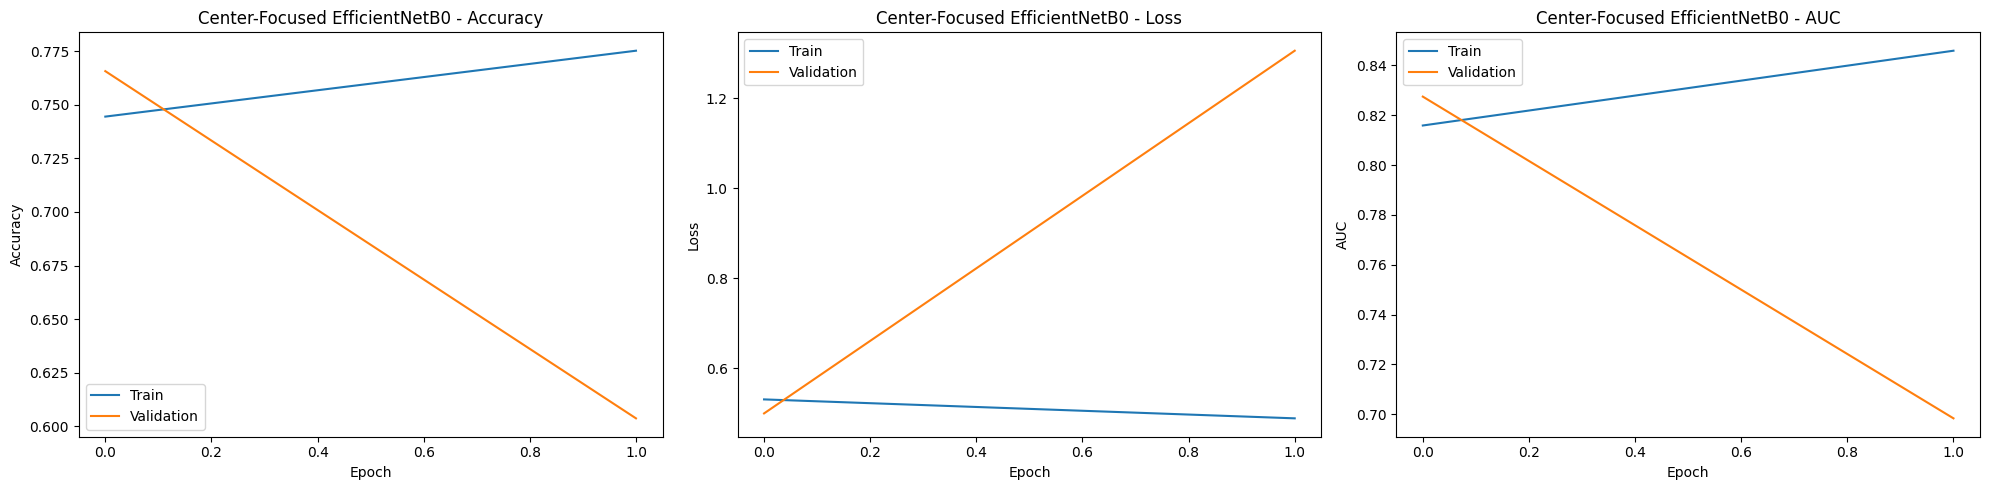

344/344 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step

Evaluation metrics for Center-Focused EfficientNetB0:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     13091
           1       0.72      0.70      0.71      8912

    accuracy                           0.77     22003
   macro avg       0.76      0.75      0.76     22003
weighted avg       0.76      0.77      0.77     22003



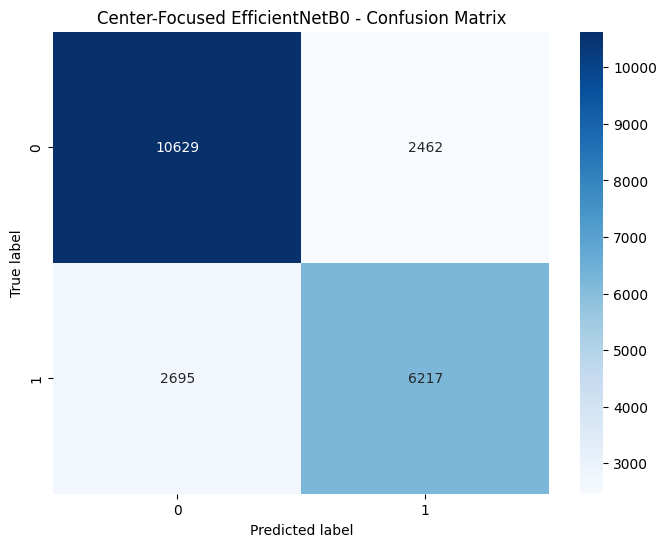

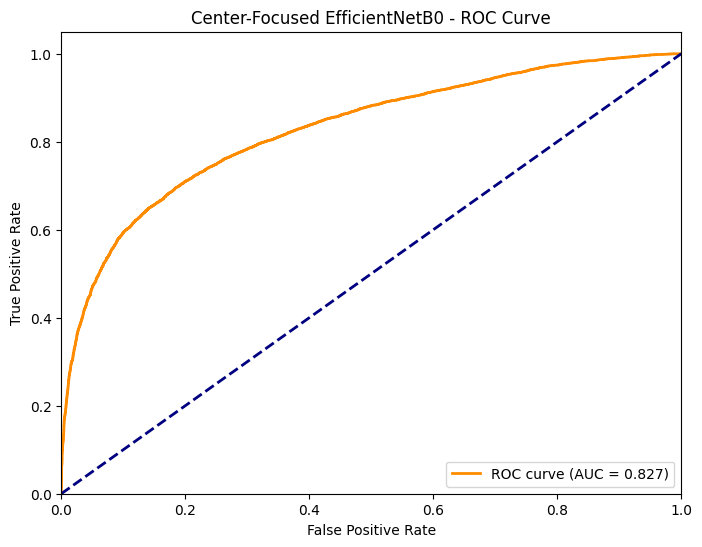

Center-Focused EfficientNetB0 final validation AUC: 0.8275

========== Training DenseNet121 with Attention ==========
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 3, 3, 1024)     │      7,037,504 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 3, 3, 64)       │         65,600 │ densenet121[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 3, 3, 1)        │             65 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 3, 3, 1024)     │              0 │ densenet121[0][0],     │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ multiply[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1024)           │          4,096 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            513 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,632,578 (29.12 MB)

 Trainable params: 593,026 (2.26 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

Epoch 1/15
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7780 - auc: 0.8565 - loss: 0.4693
Epoch 1: val_auc improved from -inf to 0.93326, saving model to model_checkpoint_DenseNet121 with Attention.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 419s 286ms/step - accuracy: 0.7781 - auc: 0.8566 - loss: 0.4692 - val_accuracy: 0.8632 - val_auc: 0.9333 - val_loss: 0.3196 - learning_rate: 1.0000e-04
Epoch 2/15
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8393 - auc: 0.9174 - loss: 0.3653
Epoch 2: val_auc improved from 0.93326 to 0.94091, saving model to model_checkpoint_DenseNet121 with Attention.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 355s 257ms/step - accuracy: 0.8393 - auc: 0.9174 - loss: 0.3653 - val_accuracy: 0.8703 - val_auc: 0.9409 - val_loss: 0.3012 - learning_rate: 1.0000e-04
Epoch 3/15
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8514 - auc: 0.9273 - loss: 0.3424
Epoch 3: val_auc improved from 0.94091 to 0.94373, saving model to model_checkpoint_DenseNe

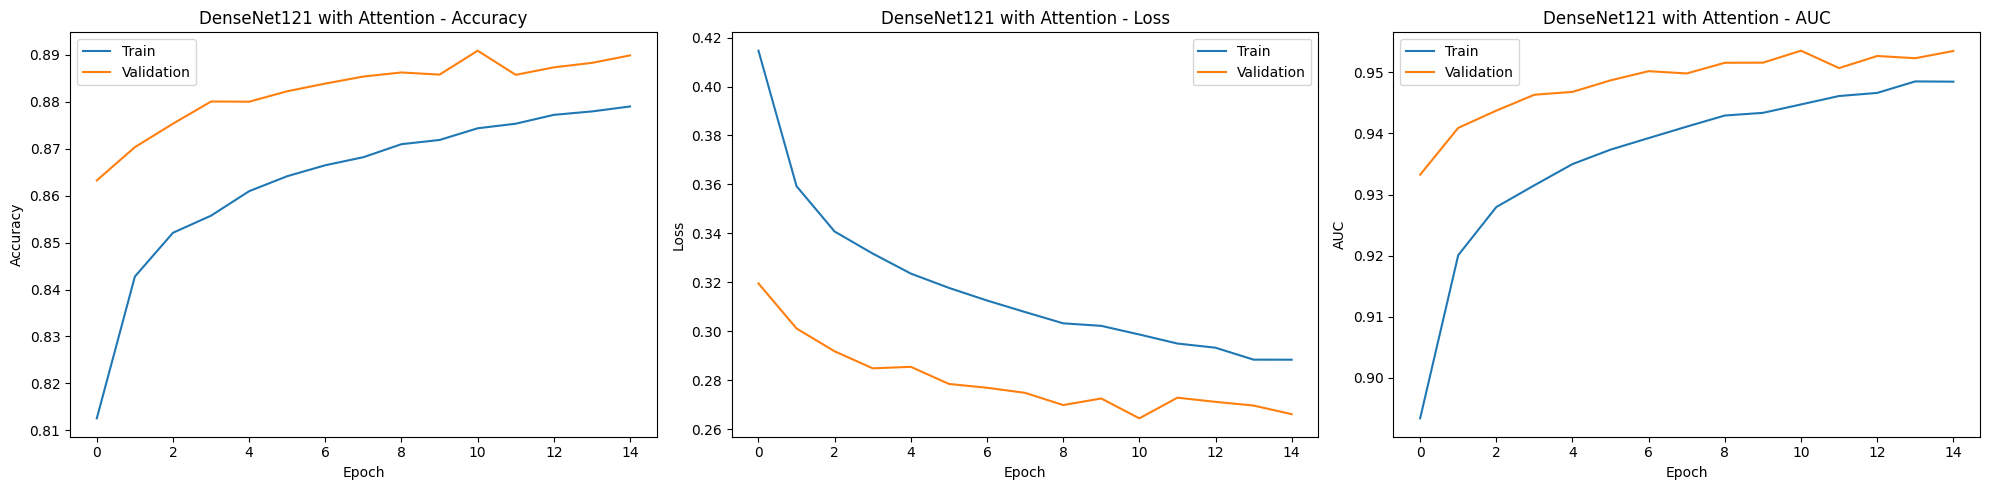

344/344 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step

Evaluation metrics for DenseNet121 with Attention:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     13091
           1       0.90      0.83      0.86      8912

    accuracy                           0.89     22003
   macro avg       0.89      0.88      0.89     22003
weighted avg       0.89      0.89      0.89     22003



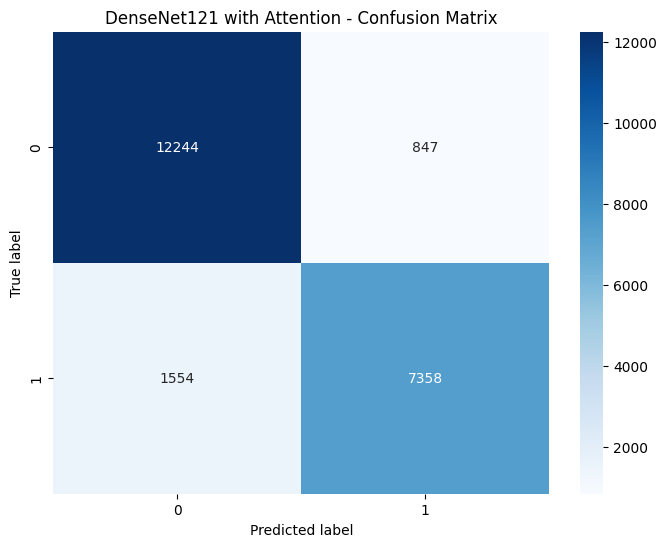

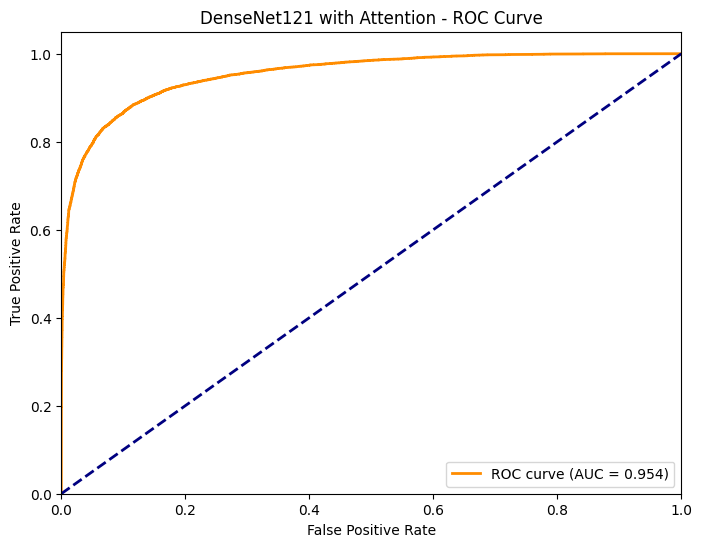

DenseNet121 with Attention final validation AUC: 0.9535

========== Training ResNet50 with Center ROI ==========
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 3, 3, 2048)     │     23,587,712 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 1, 2048)     │              0 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4096)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 4096)           │         16,384 │ concatenate_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │      1,048,832 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            257 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,653,185 (94.04 MB)

 Trainable params: 1,057,281 (4.03 MB)

 Non-trainable params: 23,595,904 (90.01 MB)

Epoch 1/2
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6841 - auc: 0.7519 - loss: 0.5919
Epoch 1: val_auc improved from -inf to 0.80112, saving model to model_checkpoint_ResNet50 with Center ROI.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 342s 240ms/step - accuracy: 0.6841 - auc: 0.7519 - loss: 0.5919 - val_accuracy: 0.7243 - val_auc: 0.8011 - val_loss: 0.5444 - learning_rate: 1.0000e-04
Epoch 2/2
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7297 - auc: 0.8110 - loss: 0.5320
Epoch 2: val_auc improved from 0.80112 to 0.81082, saving model to model_checkpoint_ResNet50 with Center ROI.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 346s 251ms/step - accuracy: 0.7297 - auc: 0.8110 - loss: 0.5320 - val_accuracy: 0.7317 - val_auc: 0.8108 - val_loss: 0.5337 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.


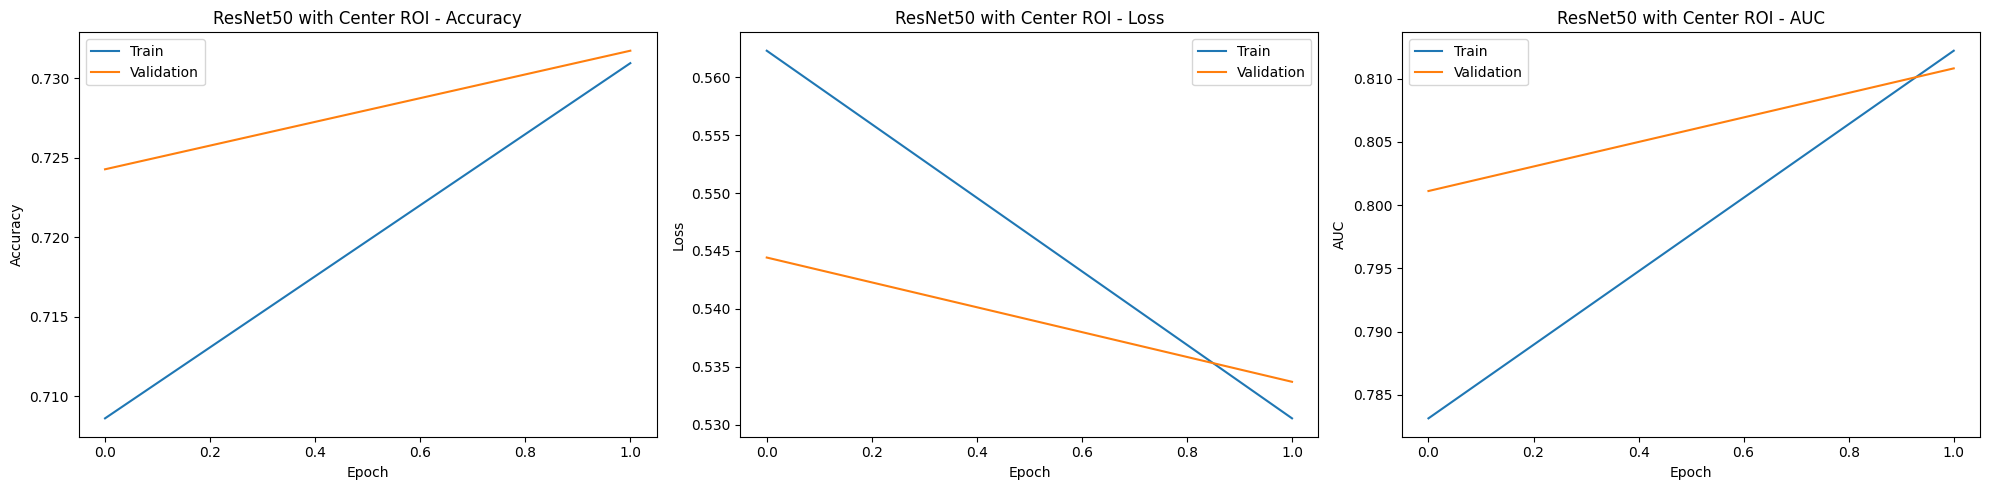

344/344 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step

Evaluation metrics for ResNet50 with Center ROI:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79     13091
           1       0.73      0.53      0.61      8912

    accuracy                           0.73     22003
   macro avg       0.73      0.70      0.70     22003
weighted avg       0.73      0.73      0.72     22003



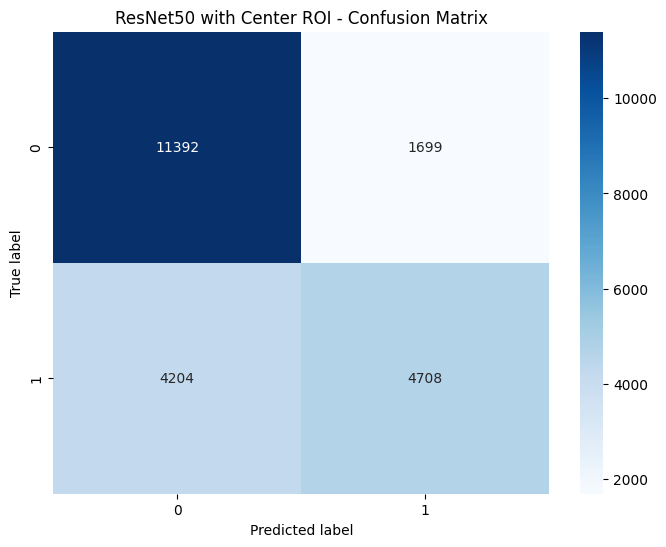

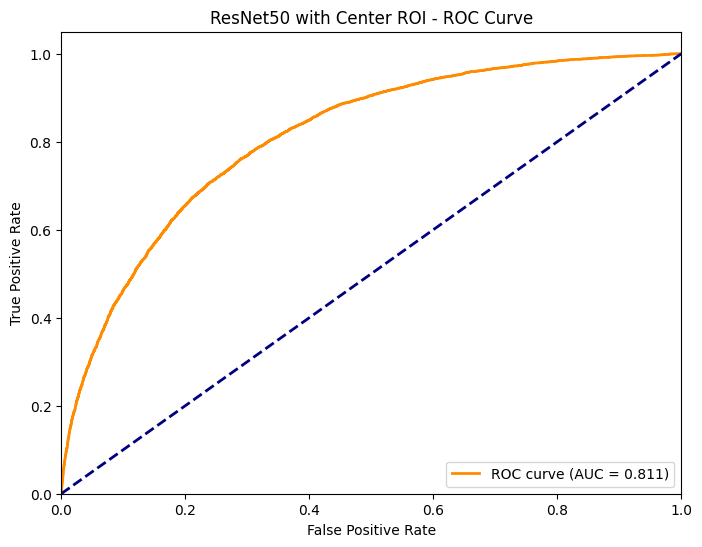

ResNet50 with Center ROI final validation AUC: 0.8109

Best model is DenseNet121 with Attention with validation AUC of 0.9535

========== Fine-tuning DenseNet121 with Attention ==========
Epoch 1/10
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8689 - auc: 0.9379 - loss: 0.3210
Epoch 1: val_auc improved from -inf to 0.95106, saving model to model_checkpoint_DenseNet121 with Attention_fine_tuned.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 411s 278ms/step - accuracy: 0.8689 - auc: 0.9379 - loss: 0.3209 - val_accuracy: 0.8861 - val_auc: 0.9511 - val_loss: 0.2720 - learning_rate: 1.0000e-05
Epoch 2/10
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8725 - auc: 0.9446 - loss: 0.2986
Epoch 2: val_auc improved from 0.95106 to 0.95219, saving model to model_checkpoint_DenseNet121 with Attention_fine_tuned.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 361s 261ms/step - accuracy: 0.8725 - auc: 0.9446 - loss: 0.2986 - val_accuracy: 0.8881 - val_auc: 0.9522 - val_loss: 0.2695 - learning_ra

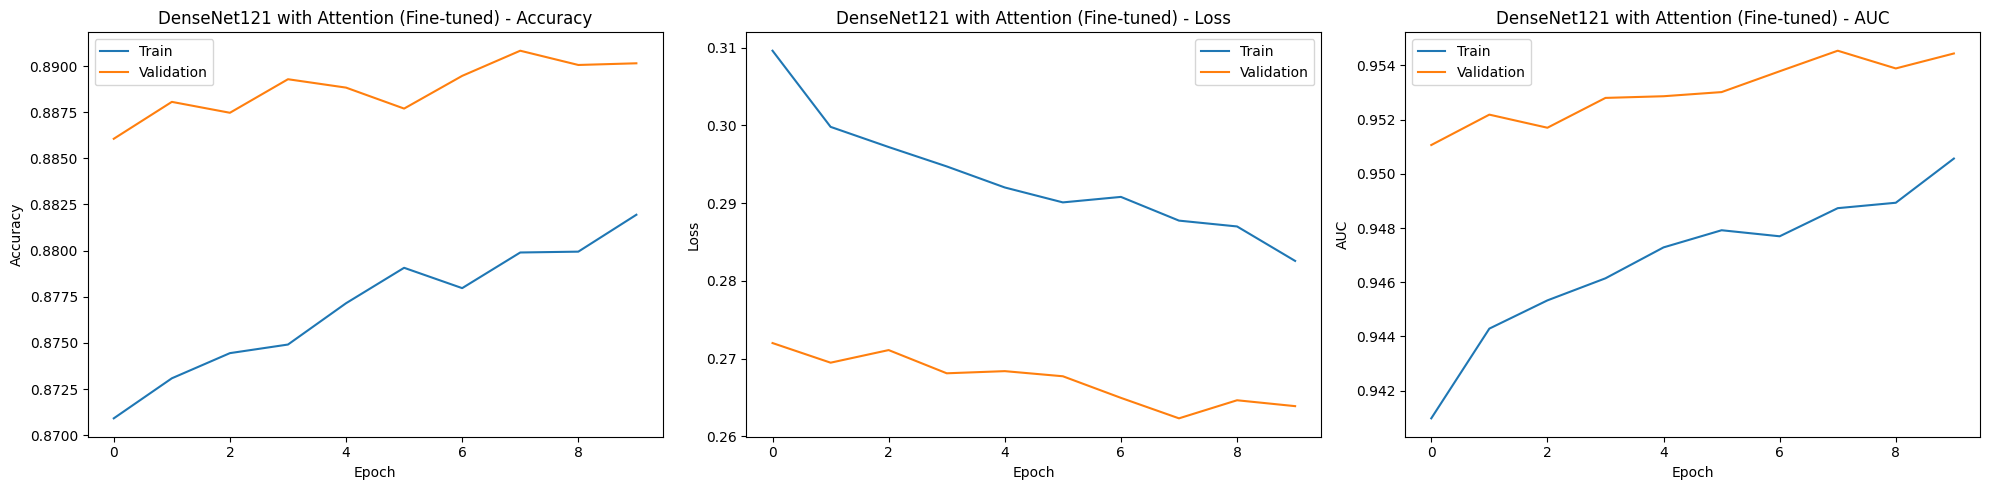

344/344 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step

Evaluation metrics for DenseNet121 with Attention (Fine-tuned):
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     13091
           1       0.89      0.83      0.86      8912

    accuracy                           0.89     22003
   macro avg       0.89      0.88      0.89     22003
weighted avg       0.89      0.89      0.89     22003



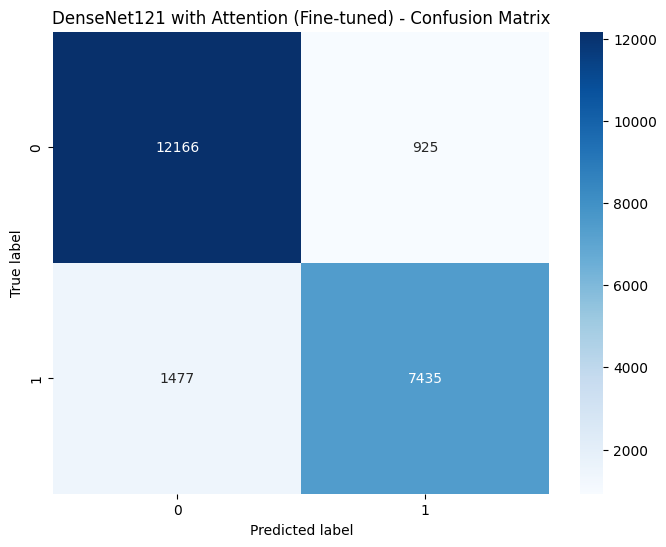

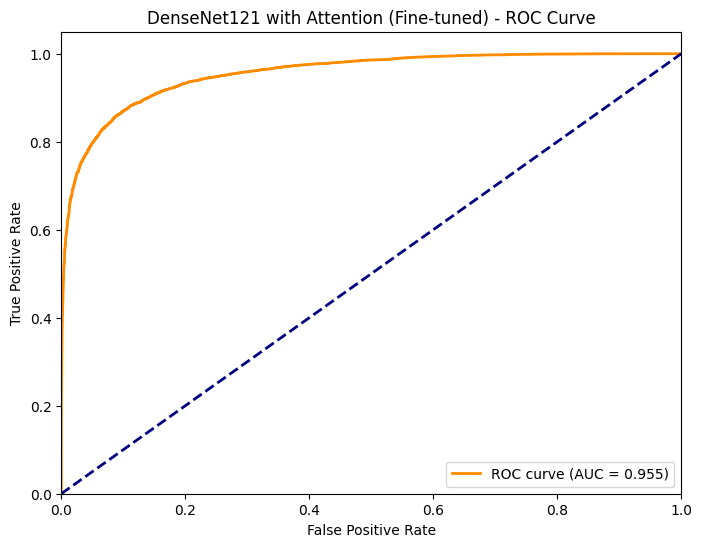

DenseNet121 with Attention fine-tuned validation AUC: 0.9547

Model Comparison:
                                model_name   val_auc
3  DenseNet121 with Attention (Fine-tuned)  0.954681
1               DenseNet121 with Attention  0.953549
0            Center-Focused EfficientNetB0  0.827468
2                 ResNet50 with Center ROI  0.810876

Generating Kaggle submission with DenseNet121 with Attention (Fine-tuned)
Found 57458 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 305s 332ms/step
Submission saved to submission_densenet121_with_attention_(fine-tuned).csv


In [16]:
# Initialize results list to track model performance
results = []

# Train and evaluate Model 1: Center-Focused EfficientNetB0
model1, history1, auc1 = train_and_evaluate_model(
    build_center_focused_efficientnet, 
    "Center-Focused EfficientNetB0", 
    epochs=2
)
results.append({
    "model_name": "Center-Focused EfficientNetB0",
    "val_auc": auc1
})

# Train and evaluate Model 2: DenseNet121 with Attention
model2, history2, auc2 = train_and_evaluate_model(
    build_densenet_with_attention, 
    "DenseNet121 with Attention", 
    epochs=15
)
results.append({
    "model_name": "DenseNet121 with Attention",
    "val_auc": auc2
})

# Train and evaluate Model 3: ResNet50 with Center ROI Pooling
model3, history3, auc3 = train_and_evaluate_model(
    build_resnet_with_center_roi, 
    "ResNet50 with Center ROI", 
    epochs=2
)
results.append({
    "model_name": "ResNet50 with Center ROI",
    "val_auc": auc3
})

# Find the best performing model
best_idx = np.argmax([r["val_auc"] for r in results])
best_model_name = results[best_idx]["model_name"]
best_model = [model1, model2, model3][best_idx]

print(f"\nBest model is {best_model_name} with validation AUC of {results[best_idx]['val_auc']:.4f}")

# Fine-tune the best model
fine_tuned_model, ft_history, ft_auc = fine_tune_model(
    best_model,
    best_model_name,
    unfreeze_layers=20,
    epochs=10
)

if ft_auc:
    results.append({
        "model_name": f"{best_model_name} (Fine-tuned)",
        "val_auc": ft_auc
    })

# Compare all models
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values(by="val_auc", ascending=False))

# Generate a Kaggle submission with the best model
best_final_idx = np.argmax([r["val_auc"] for r in results])
best_final_model_name = results[best_final_idx]["model_name"]

if "Fine-tuned" in best_final_model_name:
    final_model = fine_tuned_model
else:
    final_model = [model1, model2, model3][np.argmax([auc1, auc2, auc3])]

print(f"\nGenerating Kaggle submission with {best_final_model_name}")
submission_df = generate_kaggle_submission(
    final_model, 
    f"submission_{best_final_model_name.replace(' ', '_').lower()}.csv"
)


========== Fine-tuning DenseNet121 with Attention ==========
Epoch 1/10
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8794 - auc: 0.9483 - loss: 0.2890
Epoch 1: val_auc improved from -inf to 0.95470, saving model to model_checkpoint_DenseNet121 with Attention_fine_tuned.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 425s 290ms/step - accuracy: 0.8794 - auc: 0.9483 - loss: 0.2890 - val_accuracy: 0.8912 - val_auc: 0.9547 - val_loss: 0.2622 - learning_rate: 1.0000e-05
Epoch 2/10
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8800 - auc: 0.9490 - loss: 0.2869
Epoch 2: val_auc improved from 0.95470 to 0.95490, saving model to model_checkpoint_DenseNet121 with Attention_fine_tuned.keras
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 348s 251ms/step - accuracy: 0.8800 - auc: 0.9490 - loss: 0.2869 - val_accuracy: 0.8906 - val_auc: 0.9549 - val_loss: 0.2616 - learning_rate: 1.0000e-05
Epoch 3/10
1375/1376 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8790 - auc: 0.9492 - loss: 0.2869
Epoch 3

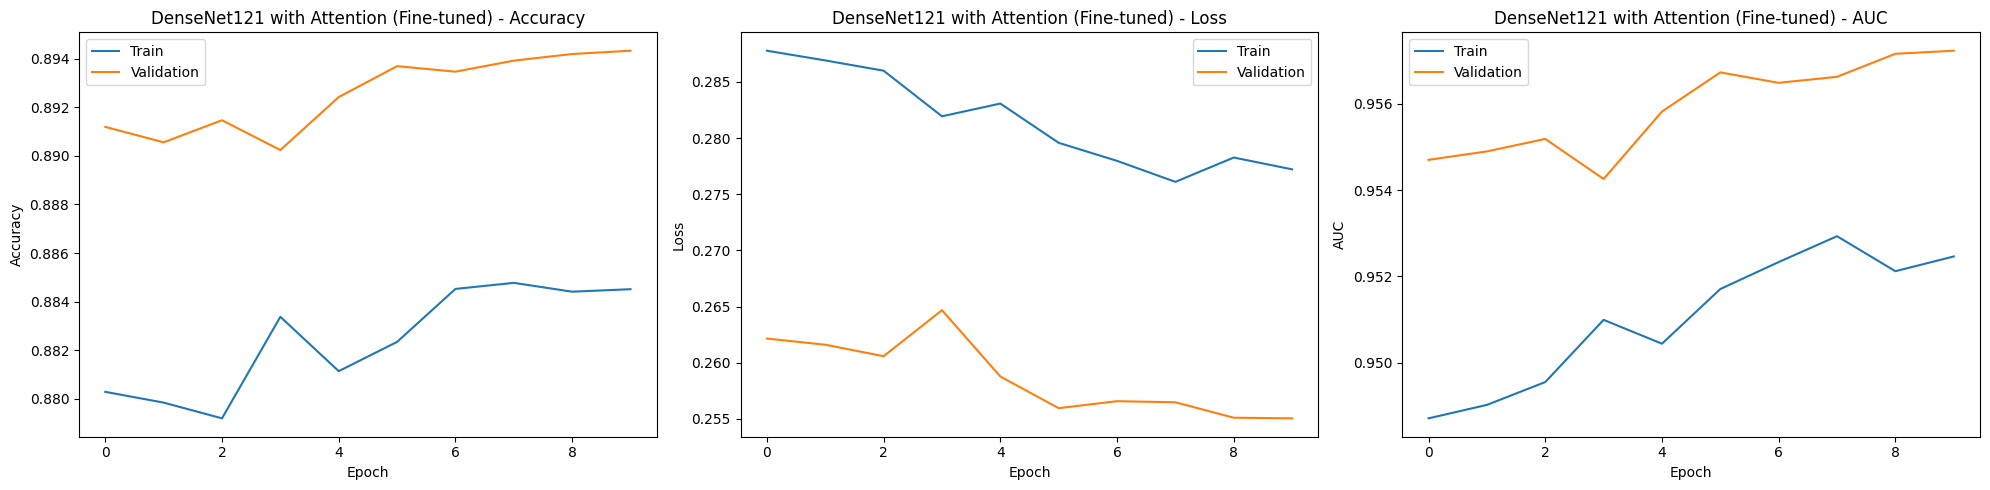

344/344 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step

Evaluation metrics for DenseNet121 with Attention (Fine-tuned):
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     13091
           1       0.90      0.83      0.86      8912

    accuracy                           0.89     22003
   macro avg       0.90      0.88      0.89     22003
weighted avg       0.89      0.89      0.89     22003



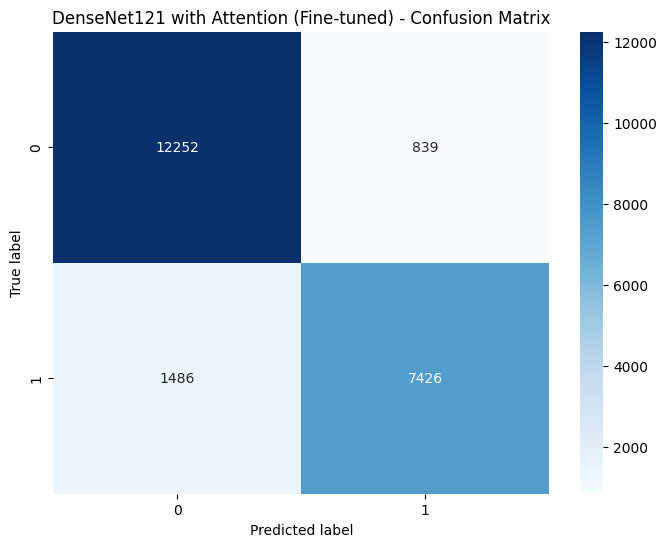

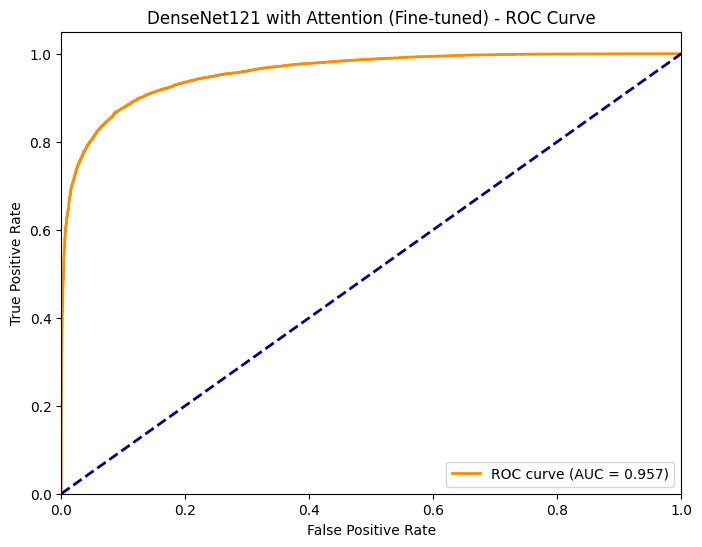

DenseNet121 with Attention fine-tuned validation AUC: 0.9573

Model Comparison:
                                model_name   val_auc
4  DenseNet121 with Attention (Fine-tuned)  0.957330
3  DenseNet121 with Attention (Fine-tuned)  0.954681
1               DenseNet121 with Attention  0.953549
0            Center-Focused EfficientNetB0  0.827468
2                 ResNet50 with Center ROI  0.810876

Generating Kaggle submission with DenseNet121 with Attention (Fine-tuned)
Found 57458 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 85s 87ms/step
Submission saved to submission_densenet121_with_attention_(fine-tuned).csv


In [17]:
# Fine-tune the best model
fine_tuned_model, ft_history, ft_auc = fine_tune_model(
    best_model,
    best_model_name,
    unfreeze_layers=20,
    epochs=10
)

if ft_auc:
    results.append({
        "model_name": f"{best_model_name} (Fine-tuned)",
        "val_auc": ft_auc
    })

# Compare all models
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values(by="val_auc", ascending=False))

# Generate a Kaggle submission with the best model
best_final_idx = np.argmax([r["val_auc"] for r in results])
best_final_model_name = results[best_final_idx]["model_name"]

if "Fine-tuned" in best_final_model_name:
    final_model = fine_tuned_model
else:
    final_model = [model1, model2, model3][np.argmax([auc1, auc2, auc3])]

print(f"\nGenerating Kaggle submission with {best_final_model_name}")
submission_df = generate_kaggle_submission(
    final_model, 
    f"submission_{best_final_model_name.replace(' ', '_').lower()}.csv"
)

# Hyperparameter Tuning

In [18]:
from sklearn.model_selection import ParameterGrid
import time

def build_densenet_with_attention(dropout_rate=0.5, learning_rate=1e-4):
    """
    DenseNet121 with attention mechanism for histopathology images
    Modified to accept hyperparameters
    """
    # Base model
    base_model = tf.keras.applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_SHAPE
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create model
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
    
    # Process through DenseNet
    x = base_model(inputs)
    
    # Add attention mechanism
    attention_features = tf.keras.layers.Conv2D(64, (1, 1), activation='relu')(x)
    attention_features = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(attention_features)
    
    # Apply attention weights
    x = tf.keras.layers.Multiply()([x, attention_features])
    
    # Global pooling and final layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [19]:
def run_hyperparameter_tuning(train_generator, validation_generator, class_weights):
    """
    Perform hyperparameter tuning for the DenseNet121 with Attention model
    """
    # Define hyperparameter grid
    param_grid = {
        'learning_rate': [1e-3, 5e-4, 1e-4, 5e-5],
        'dropout_rate': [0.3, 0.5, 0.7],
        'batch_size': [16, 32, 64, 128]
    }
    
    # Create a grid of hyperparameter combinations
    grid = list(ParameterGrid(param_grid))
    print(f"Total hyperparameter combinations: {len(grid)}")
    
    # Results storage
    results = []
    
    # Loop through hyperparameter combinations
    for params in grid:
        print(f"\n\nTesting hyperparameters: {params}")
        
        # Adjust batch size if needed
        if train_generator.batch_size != params['batch_size']:
            print(f"Note: Batch size changes would require recreating data generators.")
            # For this example, we'll just note it and continue with the current batch size
        
        # Build model with these hyperparameters
        model = build_densenet_with_attention(
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Create callbacks for this run
        early_stopping = callbacks.EarlyStopping(
            monitor='val_auc',
            patience=3,
            mode='max',
            restore_best_weights=True
        )
        
        # Train for a limited number of epochs to save time during tuning
        start_time = time.time()
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=10,  # Reduced epochs for faster tuning
            class_weight=class_weights,
            callbacks=[early_stopping],
            verbose=1
        )
        training_time = time.time() - start_time
        
        # Evaluate the model
        val_loss, val_acc, val_auc = model.evaluate(validation_generator, verbose=0)
        
        # Record results
        results.append({
            'learning_rate': params['learning_rate'],
            'dropout_rate': params['dropout_rate'],
            'batch_size': params['batch_size'],
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_auc': val_auc,
            'training_time': training_time,
            'epochs_trained': len(history.history['loss'])
        })
        
        # Print current results
        print(f"Results: val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}, val_auc={val_auc:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
        
        # Clear memory
        tf.keras.backend.clear_session()
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    return results_df

In [20]:
def analyze_hyperparameter_results(results_df):
    """
    Analyze and visualize hyperparameter tuning results
    """
    # Sort by validation AUC (primary metric)
    results_df = results_df.sort_values('val_auc', ascending=False).reset_index(drop=True)
    
    print("Top 5 hyperparameter combinations:")
    print(results_df.head())
    
    # Plot effect of learning rate
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='learning_rate', y='val_auc', data=results_df)
    plt.title('Effect of Learning Rate on Validation AUC')
    plt.xscale('log')
    
    # Plot effect of dropout rate
    plt.subplot(1, 2, 2)
    sns.boxplot(x='dropout_rate', y='val_auc', data=results_df)
    plt.title('Effect of Dropout Rate on Validation AUC')
    plt.tight_layout()
    plt.show()
    
    # Plot effect of batch size
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='batch_size', y='val_auc', data=results_df)
    plt.title('Effect of Batch Size on Validation AUC')
    plt.tight_layout()
    plt.show()
    
    # Heatmap of learning rate vs dropout rate (averaging across batch sizes)
    pivot_table = results_df.pivot_table(
        values='val_auc', 
        index='learning_rate', 
        columns='dropout_rate', 
        aggfunc='mean'
    )
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.4f')
    plt.title('Average Validation AUC by Learning Rate and Dropout Rate')
    plt.tight_layout()
    plt.show()
    
    # Training time analysis
    plt.figure(figsize=(10, 5))
    sns.barplot(x='batch_size', y='training_time', data=results_df)
    plt.title('Effect of Batch Size on Training Time')
    plt.tight_layout()
    plt.show()
    
    # Find best hyperparameters
    best_params = results_df.iloc[0].to_dict()
    print("\nBest hyperparameters:")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Dropout Rate: {best_params['dropout_rate']}")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Validation AUC: {best_params['val_auc']:.4f}")
    
    return best_params

In [21]:
def train_with_best_params(train_generator, validation_generator, class_weights, best_params):
    """
    Train the model with the best hyperparameters for more epochs
    """
    print(f"\nTraining final model with best hyperparameters:")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Dropout Rate: {best_params['dropout_rate']}")
    print(f"Batch Size: {best_params['batch_size']}")
    
    
    # Build model with best hyperparameters
    model = build_densenet_with_attention(
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )
    
    # Create callbacks for final training
    checkpoint = callbacks.ModelCheckpoint(
        "best_densenet_tuned.keras",
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    )
    
    early_stopping = callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=5,
        mode='max',
        min_lr=1e-7
    )
    
    # Train for more epochs with best hyperparameters
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=20,  # More epochs for final training
        class_weight=class_weights,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy (Tuned)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss (Tuned)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    # Plot AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC (Tuned)')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate final model
    val_loss, val_acc, val_auc = model.evaluate(validation_generator, verbose=1)
    print(f"\nFinal tuned model performance:")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    
    return model, history


In [22]:
# Execute hyperparameter tuning 
def run_optimized_subset_tuning(train_generator, validation_generator, class_weights):
    """
    Run a smaller subset of hyperparameter tuning to save time
    """
    # Define a smaller hyperparameter grid
    param_grid = {
        'learning_rate': [5e-4, 1e-4],  
        'dropout_rate': [0.3, 0.5],     
        'batch_size': [32, 64]          
    }
    
    # Create a grid of hyperparameter combinations
    grid = list(ParameterGrid(param_grid))
    print(f"Testing {len(grid)} hyperparameter combinations...")
    
    # Results storage
    results = []
    
    # Loop through hyperparameter combinations
    for params in grid:
        print(f"\n\nTesting hyperparameters: {params}")
        
        # Build model with these hyperparameters
        model = build_densenet_with_attention(
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Create callbacks for this run
        early_stopping = callbacks.EarlyStopping(
            monitor='val_auc',
            patience=3,
            mode='max',
            restore_best_weights=True
        )
        
        # Train for a limited number of epochs
        start_time = time.time()
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=5,  # Just a few epochs for quick testing
            class_weight=class_weights,
            callbacks=[early_stopping],
            verbose=1
        )
        training_time = time.time() - start_time
        
        # Evaluate the model
        val_loss, val_acc, val_auc = model.evaluate(validation_generator, verbose=0)
        
        # Record results
        results.append({
            'learning_rate': params['learning_rate'],
            'dropout_rate': params['dropout_rate'],
            'batch_size': params['batch_size'],
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_auc': val_auc,
            'training_time': training_time,
            'epochs_trained': len(history.history['loss'])
        })
        
        # Print current results
        print(f"Results: val_auc={val_auc:.4f}, val_accuracy={val_acc:.4f}")
        
        # Clear memory
        tf.keras.backend.clear_session()
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    return results_df

results_df = run_optimized_subset_tuning(train_generator, validation_generator, class_weights)

Testing 8 hyperparameter combinations...


Testing hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.0005}
Epoch 1/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 384s 263ms/step - accuracy: 0.8192 - auc: 0.8996 - loss: 0.4010 - val_accuracy: 0.8725 - val_auc: 0.9442 - val_loss: 0.2974
Epoch 2/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 350s 253ms/step - accuracy: 0.8578 - auc: 0.9342 - loss: 0.3250 - val_accuracy: 0.8775 - val_auc: 0.9445 - val_loss: 0.2912
Epoch 3/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 350s 253ms/step - accuracy: 0.8707 - auc: 0.9413 - loss: 0.3081 - val_accuracy: 0.8792 - val_auc: 0.9457 - val_loss: 0.2864
Epoch 4/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 345s 250ms/step - accuracy: 0.8683 - auc: 0.9415 - loss: 0.3077 - val_accuracy: 0.8767 - val_auc: 0.9463 - val_loss: 0.2938
Epoch 5/5
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 348s 252ms/step - accuracy: 0.8777 - auc: 0.9471 - loss: 0.2920 - val_accuracy: 0.8792 - val_auc: 0.9478 - val_loss: 0.2942
Results: val_auc=0.9478, val_accuracy=0.87

Top 5 hyperparameter combinations:
   learning_rate  dropout_rate  batch_size  val_loss  val_accuracy   val_auc  \
0         0.0005           0.5          64  0.264796      0.888697  0.953861   
1         0.0005           0.3          64  0.267541      0.888742  0.952957   
2         0.0005           0.5          32  0.269756      0.887606  0.951816   
3         0.0001           0.3          64  0.271782      0.885834  0.951204   
4         0.0001           0.5          32  0.284043      0.883016  0.948870   

   training_time  epochs_trained  
0    1783.538732               5  
1    1752.595176               5  
2    1823.514154               5  
3    1684.094757               5  
4    1710.914032               5  


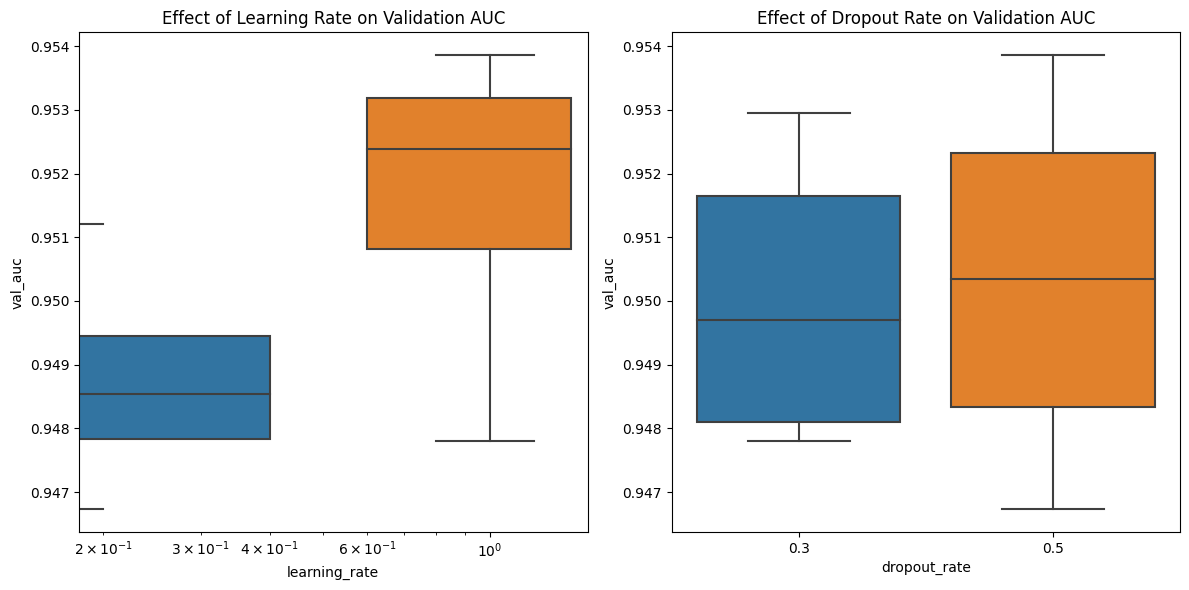

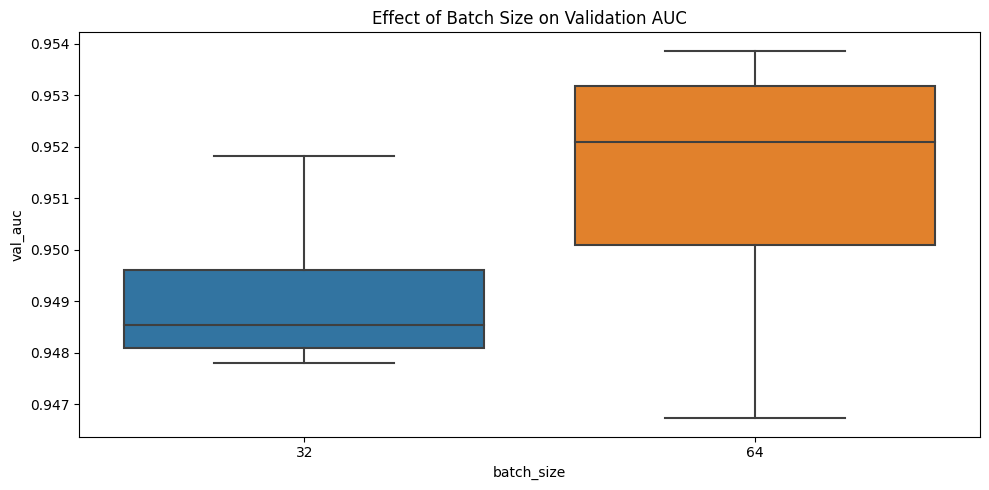

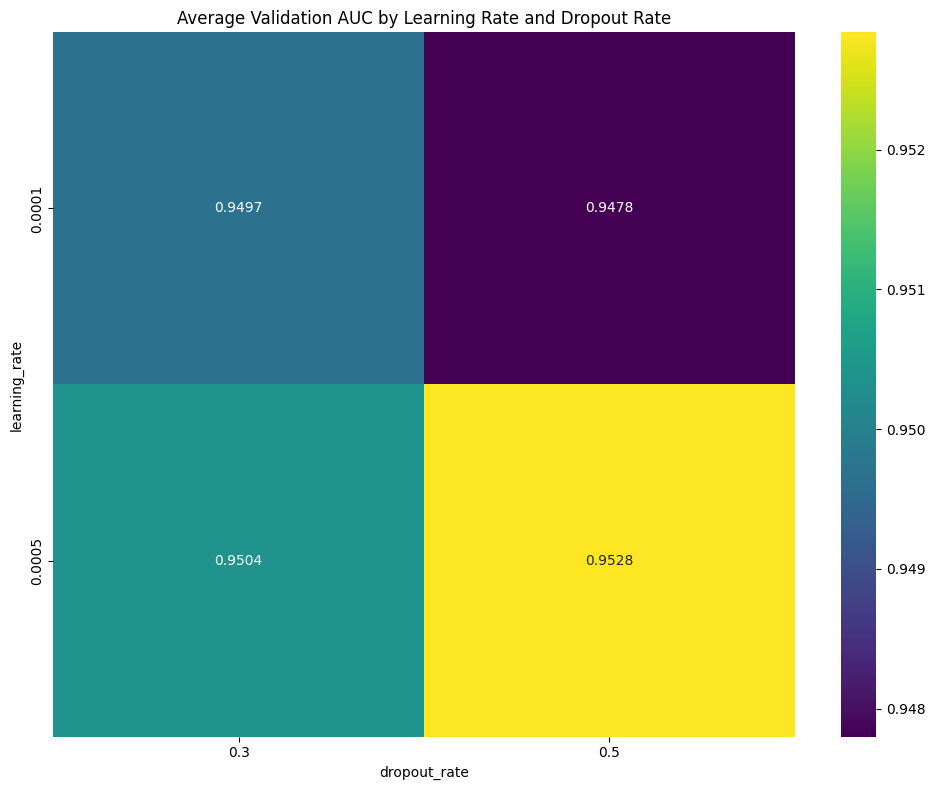

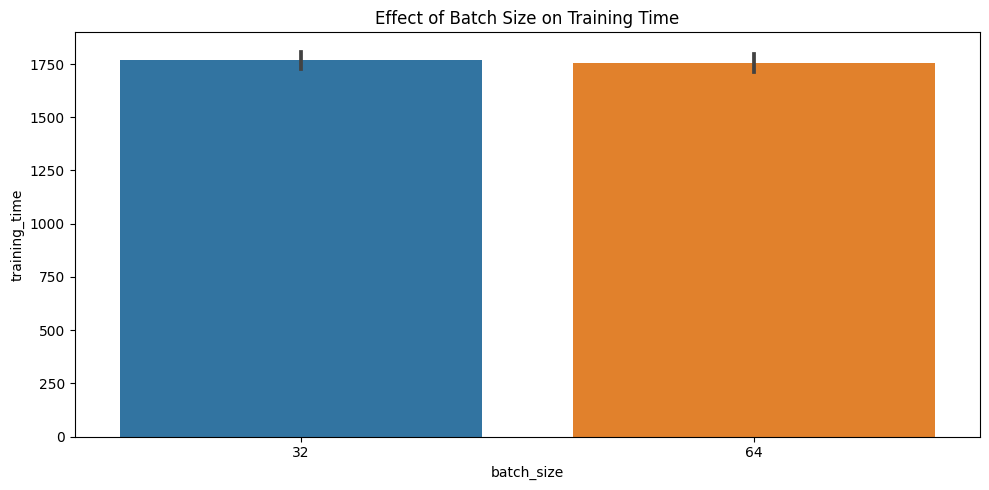


Best hyperparameters:
Learning Rate: 0.0005
Dropout Rate: 0.5
Batch Size: 64.0
Validation AUC: 0.9539

Training final model with best hyperparameters:
Learning Rate: 0.0005
Dropout Rate: 0.5
Batch Size: 64.0
Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 398s 274ms/step - accuracy: 0.8107 - auc: 0.8898 - loss: 0.4213 - val_accuracy: 0.8715 - val_auc: 0.9394 - val_loss: 0.3026 - learning_rate: 5.0000e-04
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 361s 261ms/step - accuracy: 0.8569 - auc: 0.9311 - loss: 0.3333 - val_accuracy: 0.8727 - val_auc: 0.9418 - val_loss: 0.3023 - learning_rate: 5.0000e-04
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 356s 257ms/step - accuracy: 0.8622 - auc: 0.9367 - loss: 0.3194 - val_accuracy: 0.8770 - val_auc: 0.9447 - val_loss: 0.2897 - learning_rate: 5.0000e-04
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 364s 263ms/step - accuracy: 0.8675 - auc: 0.9408 - loss: 0.3092 - val_accuracy: 0.8804 - val_auc: 0.9494 - val_loss: 0.2809 - learning_rate: 5.0000e-04
Epoch 5/20
1376

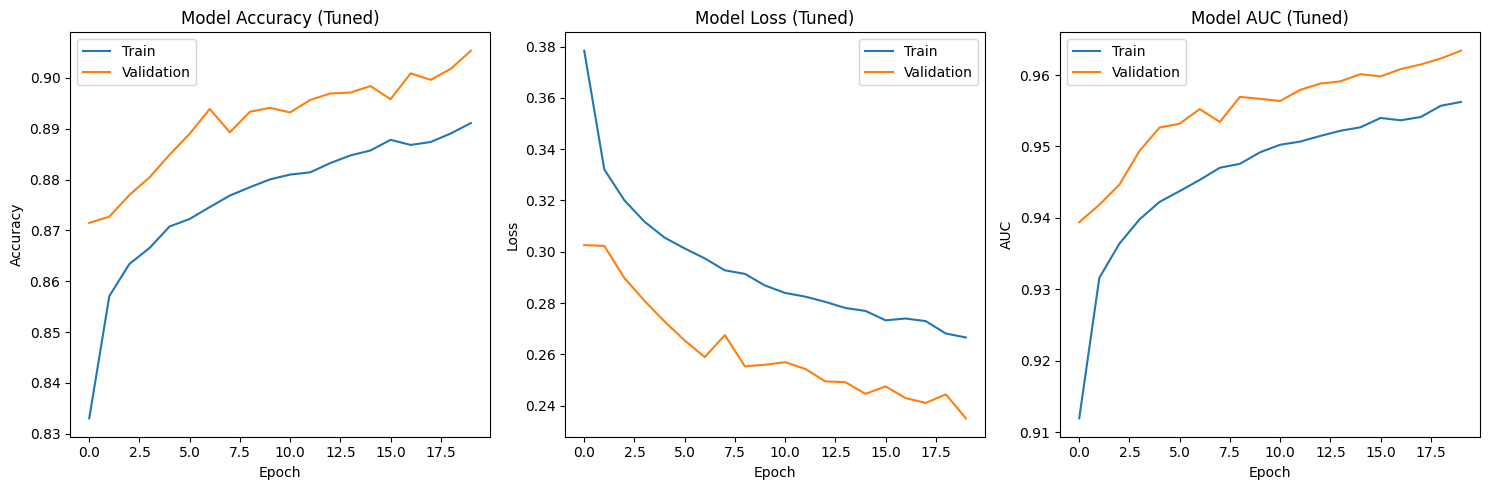

344/344 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.9053 - auc: 0.9645 - loss: 0.2329

Final tuned model performance:
Validation Loss: 0.2350
Validation Accuracy: 0.9053
Validation AUC: 0.9634


In [23]:
best_params = analyze_hyperparameter_results(results_df)
best_model, history = train_with_best_params(train_generator, validation_generator, class_weights, best_params)